# Data wrangling with "Azure ML Package for Forecasting"

## Summary
 This notebook demonstrates how to use the primary data structure - `TimeSeriesDataFrame` that comes with `Azure Machine Learning Package for Forecasting`(AMLPF). The `TimeSeriesDataFrame` is at the core of the package and it subclasses the [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). In this notebook, we will demonstrate some common data wrangling tasks that involve the `TimeSeriesDataFrame` on the [U. Chicago Dominick's Finer Foods dataset](https://research.chicagobooth.edu/kilts/marketing-databases/dominicks). 
 
 The following data wrangling tasks are shown:
 * Loading datasets
 * Working with Date strings
 * Creating TimeSeriesDataFrame
 * Changing shape of TimeSeriesDataFrame
 * Slicers with TimeSeriesDataFrame
 * Aggregation operations with TimeSeriesDataFrame
 * Merge operations with TimeSeriesDataFrame
 
**Please refer to our [programming guide](https://azuremlftkrelease.blob.core.windows.net/docsdev/html/index.html) for a full list of transfomers and models available in AMLPF and try them out.**
 

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore") 

# Import packages
import pandas as pd
import numpy as np
import math
import pkg_resources
from datetime import timedelta
import datetime
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso

from ftk import TimeSeriesDataFrame
from ftk.data import get_a_year_of_daily_weather_data

## Load Data and Explore

Any [IO tools](https://pandas.pydata.org/pandas-docs/stable/io.html) supported by Pandas can be used to load data. One of the most common ways to do so is the `read_csv` API since many datasets are distributed in that format.
In addittion to wide variety of formats, Pandas provides many ways to handle large datasets. One of the most common ways to handle is by loading them in chunks. Columnar/vector representation of datasets can be compressed to a greater degree that relational frames and are another good option.

In [2]:
# Read raw data from CSV
csv_path = pkg_resources.resource_filename('ftk', 'data/dominicks_oj/dominicks_oj.csv')
whole_df = pd.read_csv(csv_path, low_memory = False)
whole_df.head()

# Read large datasets in chunks
chunk_size = 500
chunks = []
for chunk in pd.read_csv(csv_path, chunksize=chunk_size):    
    chunks.append(chunk)
whole_df_chunked = pd.concat(chunks, axis=0)
whole_df_chunked.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.02,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
1,2,tropicana,46,8.72,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
2,2,tropicana,47,8.25,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
3,2,tropicana,48,8.99,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
4,2,tropicana,50,9.09,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38


## Working with Date strings

Pandas dataframe offers extensive support to working with time-series and thus Date objects in general. A common
requirement is to convert datetime strings to DateTime objects. Pandas has datetime objects that model them as a single
point in time via the `Timestamp` or a as a time range/period - `Period`. In `TimeSeriesDataFrame` we assume the Date index to be of `Timestamp` type and hence the time axis is of type `DateTimeIndex`. This column is part of the multi-index and stored in the `time_colname` metadata property.

In [3]:
# The sales are contained in the 'logmove' column. 
# Values are logarithmic, so exponentiate and round them to get quantity sold
def expround(x):
    return math.floor(math.exp(x) + 0.5)
whole_df['quantity'] = whole_df['logmove'].apply(expround)

# Create `TimeStamp` using `to_datetime` passing in a string value 
weekZeroStart = pd.to_datetime('1989-09-07 00:00:00')
print(weekZeroStart)

# Create `TimeStamp` passing in a string value 
weekZeroStartTS = pd.Timestamp('1989-09-07 00:00:00')
print(weekZeroStartTS)

# Create `TimeStamp` with a specific format. The `to_datetime` supports
# formatters.
weekZeroStartFMT = pd.to_datetime('1989-09-07 00:00:00', format='%Y/%m/%d')
print(weekZeroStartFMT)

weekZeroEnd = pd.to_datetime('1989-09-13 23:59:59')
whole_df['WeekFirstDay'] = whole_df['week'].apply(lambda n: weekZeroStart + timedelta(weeks=n))
whole_df['WeekLastDay'] = whole_df['week'].apply(lambda n: weekZeroEnd + timedelta(weeks=n))
whole_df[['store','brand','WeekLastDay', 'quantity']].head()

1989-09-07 00:00:00
1989-09-07 00:00:00
1989-09-07 00:00:00


,store,brand,WeekLastDay,quantity
0,2,tropicana,1990-06-20 23:59:59,8256
1,2,tropicana,1990-08-01 23:59:59,6144
2,2,tropicana,1990-08-08 23:59:59,3840
3,2,tropicana,1990-08-15 23:59:59,8000
4,2,tropicana,1990-08-29 23:59:59,8896


## Create TimeSeriesDataframe

In this section below, we create a `TimeSeriesDataFrame` from a Pandas dataframe. In the TimeSeriesDataFrame representation, the time axis and grain are part of the data frame index - which is a composite or a MultiIndex in Pandas. This allows easy access to Pandas datetime slicing capabilities.

A MultiIndex is a multi-level or hierarchical representation for Pandas objects. Such an index indicates
the usage of two or more columns to uniquely differentiate or locate records. In database terms, MultiIndex is simply
a [compound](https://en.wikipedia.org/wiki/Compound_key) or composite key as used in database parlance.

You can also glean common information about the `TimeSeriesDataFrame` by using Pandas' APIs.
Some of the common statistics involve finding the shape of the dataframe, the columns and their
datatypes, the indexes and information about the indexes.

<class 'ftk.time_series_data_frame.TimeSeriesDataFrame'>
MultiIndex: 28947 entries, (1990-06-20 23:59:59, 2, tropicana) to (1992-10-07 23:59:59, 137, dominicks)
Data columns (total 17 columns):
week            28947 non-null int64
logmove         28947 non-null float64
feat            28947 non-null int64
price           28947 non-null float64
AGE60           28947 non-null float64
EDUC            28947 non-null float64
ETHNIC          28947 non-null float64
INCOME          28947 non-null float64
HHLARGE         28947 non-null float64
WORKWOM         28947 non-null float64
HVAL150         28947 non-null float64
SSTRDIST        28947 non-null float64
SSTRVOL         28947 non-null float64
CPDIST5         28947 non-null float64
CPWVOL5         28947 non-null float64
quantity        28947 non-null int64
WeekFirstDay    28947 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(13), int64(3)
memory usage: 3.8+ MB
None
(28947, 17)
          week  logmove     feat    price    AGE60    

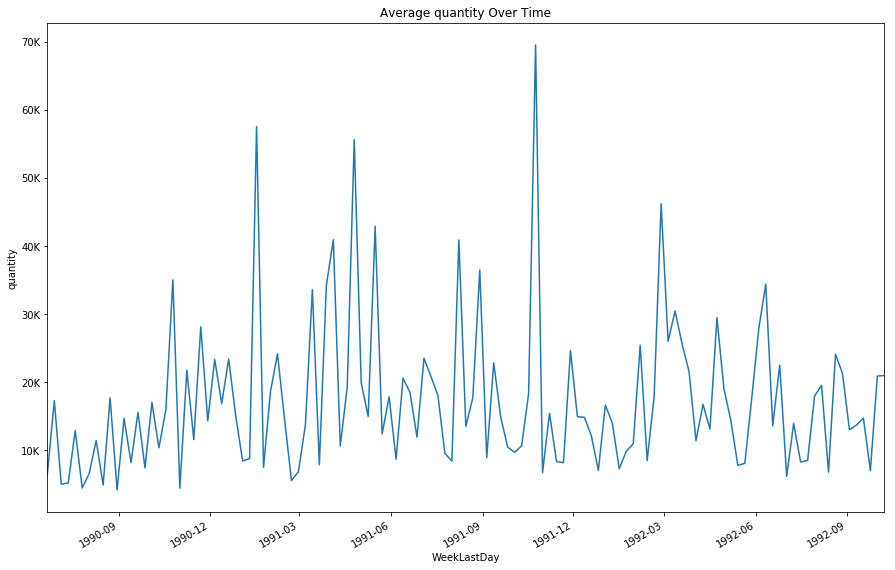

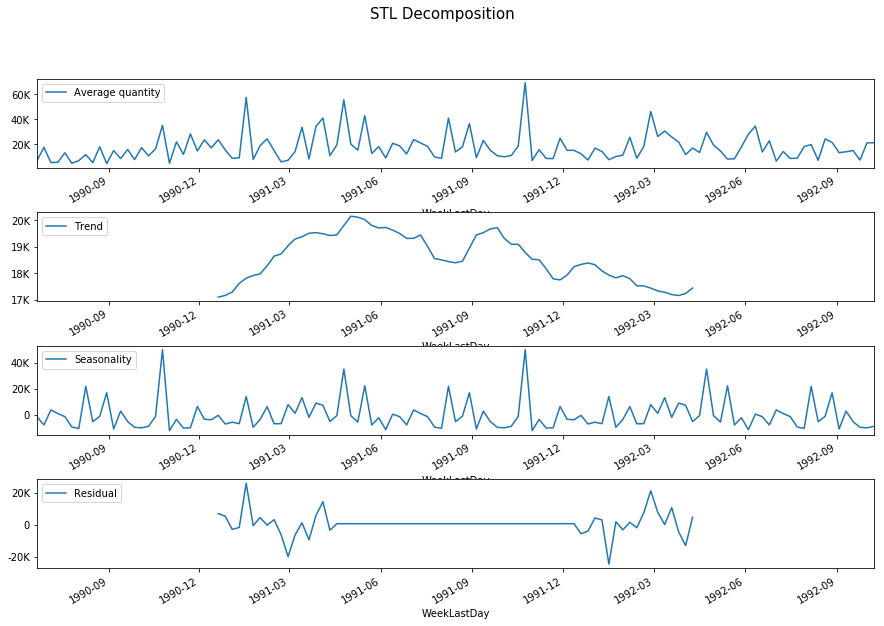

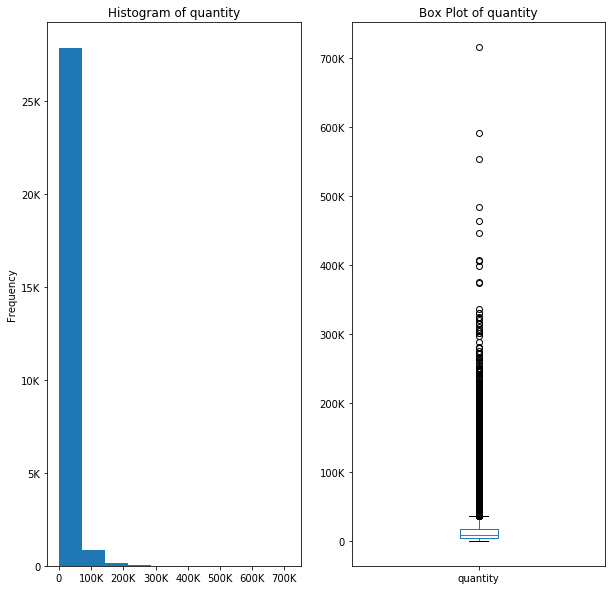

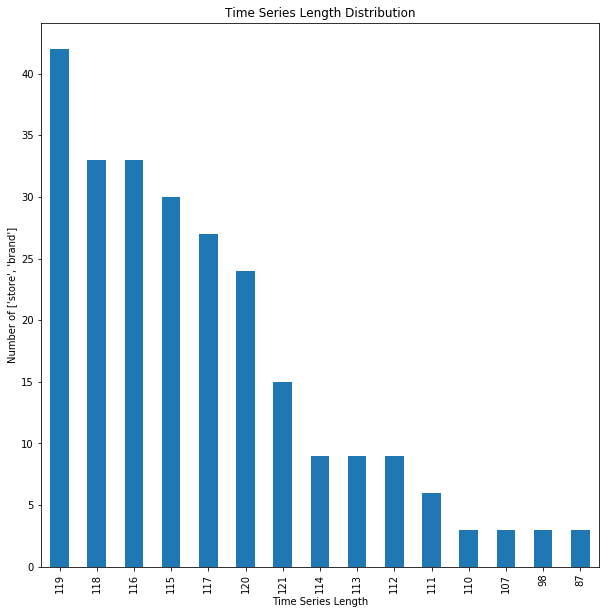

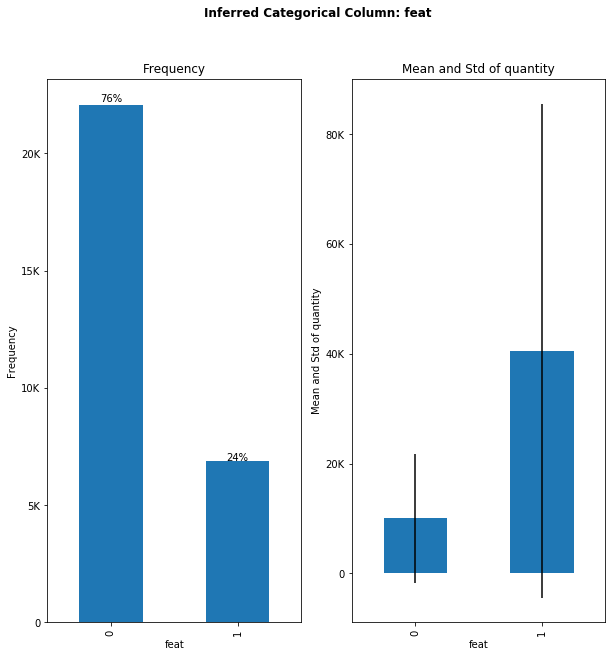

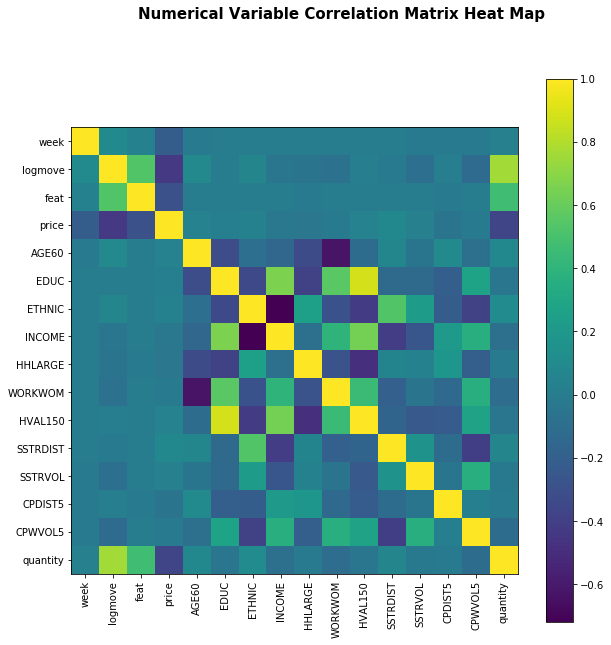

In [4]:
# Create a TimeSeriesDataFrame
# Use end of period as the time index
# Store and brand combinations label the grain 
# i.e. there is one time series for each unique pair of store and grain
whole_tsdf = TimeSeriesDataFrame(whole_df, 
                                 grain_colnames = ['store', 'brand'],
                                 time_colname = 'WeekLastDay', 
                                 ts_value_colname = 'quantity',
                                 group_colnames = 'store')

# TimeSeriesDataFrame info
print(whole_tsdf.info())

# Find info about the shape of the TimeSeriesDataframe
print(whole_tsdf.shape)

# Describe TimeSeriesDataframe
print(whole_tsdf.describe())

# Index names
print(whole_tsdf.index.names)

# Vector of unique values for specific index column
print(whole_tsdf.index.get_level_values('brand').unique())

# Print sample rows in the data frame from the top.
# Includes the default grain and time axis columns) other than
# the ones explicitly specified.
whole_tsdf[['quantity', 'price']].head()

# The ```TimeSeriesDataFrame.ts_report()``` function generates a comprehensive
# report of the time series data frame, including both general data 
# description and statistics specific to time series data. 
%matplotlib inline
whole_tsdf.ts_report()

## Changing shape of TimeSeriesDataFrame

There are several ways to add or remove columns and rows in a `TimeSeriesDataFrame`. 
In the section below, we will look at some of the most common ways to do so.

In [5]:
# Add a new column with default value 'NewColumn'
whole_tsdf['defaultcol'] = 'Default'

# Add a new composed column using values from other columns
# "Purchase impact" - ratio of income to per unit cost of item
whole_tsdf['purchimpact'] = whole_tsdf['INCOME']/whole_tsdf['price']

# Add a new column with conditional logic
whole_tsdf['isprofitable'] = np.where(whole_tsdf['price']>=2.0, True, False)

# Add a new column using Python lambda functions
def calc_tax(price):
    return price * 0.1
whole_tsdf['taxamount'] = whole_tsdf.price.apply(calc_tax)

# Remove columns by using Drop
whole_tsdf = whole_tsdf.drop(['defaultcol', 'isprofitable'], axis=1)
whole_tsdf.tail()

# Remove columns by selecting a subset of columns
whole_tsdf_subset = whole_tsdf[['price', 'quantity']]
whole_tsdf_subset.tail()

,,,price,quantity
WeekLastDay,store,brand,,
1992-09-09 23:59:59,137,dominicks,2.00,2944
1992-09-16 23:59:59,137,dominicks,1.94,4928
1992-09-23 23:59:59,137,dominicks,1.59,13440
1992-09-30 23:59:59,137,dominicks,1.49,55680
1992-10-07 23:59:59,137,dominicks,1.75,7040


## Slicers with TimeSeriesDataFrame

Pandas has powerful capabilities to slice dataframe. `TimeSeriesDataFrame` fully supports all of these operations
that are allowed on the native dataframes. Pandas offer the powerful `loc` API to slice objects using labels, but
because `TimeSeriesDataFrame` is multi indexed, the `IndexSlice` or the `slice` APIs can be used in conjunction to perform all sorts of data mangling.

**NOTE:** 
* Since there are multiple indexes in TimeSeriesDataFrame, any slice operation must specify the slice criterion for each index. 
* The indexes are ordinal with the `time_colname` being first and the `grain_colnames` columns in the order they were passed in during the creation.
* The ":" called the null slicer indicates no slicing on the specified index. Not specifying any index simply defaults to a null slice for that ordinal index.

In [6]:
# Dataframe must be sorted before slice
whole_tsdf.sort_index(inplace=True)

# Slice on a range of values with tuples. Our current TimeSeriesDataFrame
# object has the 'WeekLastDay' time column and two grain columns - 'store' and
# 'brand'. The slicing operations will this specify slice criterion for each of these 
# index columns in that order.
whole_tsdf_singleweek_store5 = whole_tsdf.loc[('1990-06-20 23:59:59', 5,), :]
whole_tsdf_singleweek_store5

week  logmove  feat  price  AGE60  \
WeekLastDay         store brand                                            
1990-06-20 23:59:59 5     dominicks      40     7.49     1   1.59   0.12   
                          minute.maid    40     8.35     0   2.99   0.12   
                          tropicana      40     8.68     0   3.66   0.12   

                                       EDUC  ETHNIC  INCOME  HHLARGE  WORKWOM  \
WeekLastDay         store brand                                                 
1990-06-20 23:59:59 5     dominicks    0.32    0.05   10.92     0.10     0.41   
                          minute.maid  0.32    0.05   10.92     0.10     0.41   
                          tropicana    0.32    0.05   10.92     0.10     0.41   

                                       HVAL150  SSTRDIST  SSTRVOL  CPDIST5  \
WeekLastDay         store brand                                              
1990-06-20 23:59:59 5     dominicks       0.54      3.80     0.68     1.60   
                          minute.maid     0.54      3.80     0.68     1.60   
                          tropicana       0.54      3.80     0.68     1.60   

                                       CPWVOL5  quantity WeekFirstDay  \
WeekLastDay         store brand                                         
1990-06-20 23:59:59 5     dominicks       0.74      1792   1990-06-14   
                          minute.maid     0.74      4224   1990-06-14   
                          tropicana       0.74      5888   1990-06-14   

                                       purchimpact  taxamount  
WeekLastDay         store brand                                
1990-06-20 23:59:59 5     dominicks           6.87       0.16  
                          minute.maid         3.65       0.30  
                          tropicana           2.98       0.37

In [22]:
# Get sales of tropicana in store 5 during summer 1990 
whole_tsdf_tropicana_store5_summer90 = whole_tsdf.loc[pd.IndexSlice['1990-06':'1990-09', 5, 'tropicana'], :]
whole_tsdf_tropicana_store5_summer90

,,,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,quantity,WeekFirstDay,purchimpact,taxamount
WeekLastDay,store,brand,,,,,,,,,,,,,,,,,,,
1990-06-20 23:59:59,5,tropicana,40,8.68,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,5888,1990-06-14,2.98,0.37
1990-07-04 23:59:59,5,tropicana,42,8.85,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,6976,1990-06-28,2.98,0.37
1990-07-11 23:59:59,5,tropicana,43,8.78,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,6528,1990-07-05,2.98,0.37
1990-07-18 23:59:59,5,tropicana,44,8.50,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4928,1990-07-12,2.98,0.37
1990-08-01 23:59:59,5,tropicana,46,8.58,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,5312,1990-07-26,2.98,0.37
1990-08-08 23:59:59,5,tropicana,47,8.54,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,5120,1990-08-02,2.98,0.37
1990-08-15 23:59:59,5,tropicana,48,8.98,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,7936,1990-08-09,2.98,0.37
1990-08-22 23:59:59,5,tropicana,49,8.71,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,6080,1990-08-16,2.98,0.37
1990-08-29 23:59:59,5,tropicana,50,8.33,0,3.66,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4160,1990-08-23,2.98,0.37


In [23]:
# Get sales of store 5 during summer 1990 
whole_tsdf_store5_summer90 = whole_tsdf.loc[pd.IndexSlice['1990-06':'1990-09', 5], :]
whole_tsdf_store5_summer90

week  logmove  feat  price  AGE60  \
WeekLastDay         store brand                                            
1990-06-20 23:59:59 5     dominicks      40     7.49     1   1.59   0.12   
                          minute.maid    40     8.35     0   2.99   0.12   
                          tropicana      40     8.68     0   3.66   0.12   
1990-07-04 23:59:59 5     dominicks      42     7.82     0   2.49   0.12   
                          minute.maid    42     8.38     0   2.99   0.12   
                          tropicana      42     8.85     0   3.66   0.12   
1990-07-11 23:59:59 5     dominicks      43     7.99     0   2.49   0.12   
                          minute.maid    43     8.50     0   2.99   0.12   
                          tropicana      43     8.78     0   3.66   0.12   
1990-07-18 23:59:59 5     dominicks      44     6.93     0   2.49   0.12   
                          minute.maid    44    10.35     1   2.59   0.12   
                          tropicana      44     8.50     0   3.66   0.12   
1990-08-01 23:59:59 5     dominicks      46     8.35     0   2.49   0.12   
                          minute.maid    46     9.22     0   2.99   0.12   
                          tropicana      46     8.58     0   3.66   0.12   
1990-08-08 23:59:59 5     dominicks      47     8.42     1   2.09   0.12   
                          minute.maid    47     9.99     1   2.39   0.12   
                          tropicana      47     8.54     0   3.66   0.12   
1990-08-15 23:59:59 5     dominicks      48     7.45     0   2.09   0.12   
                          minute.maid    48     8.42     0   2.99   0.12   
                          tropicana      48     8.98     0   3.66   0.12   
1990-08-22 23:59:59 5     dominicks      49     7.10     0   2.09   0.12   
                          minute.maid    49    10.86     1   1.99   0.12   
                          tropicana      49     8.71     0   3.66   0.12   
1990-08-29 23:59:59 5     dominicks      50     7.05     0   2.09   0.12   
                          minute.maid    50     8.18     0   2.99   0.12   
                          tropicana      50     8.33     0   3.66   0.12   
1990-09-05 23:59:59 5     dominicks      51    10.31     1   1.89   0.12   
                          minute.maid    51     8.54     0   2.99   0.12   
                          tropicana      51     8.68     0   3.66   0.12   
1990-09-12 23:59:59 5     dominicks      52     9.10     0   1.89   0.12   
                          minute.maid    52     8.39     0   2.99   0.12   
                          tropicana      52     9.16     0   3.29   0.12   
1990-09-19 23:59:59 5     dominicks      53     9.01     0   1.89   0.12   
                          minute.maid    53    10.32     1   2.19   0.12   
                          tropicana      53     9.03     0   3.29   0.12   
1990-09-26 23:59:59 5     dominicks      54     8.78     0   1.79   0.12   
                          minute.maid    54     8.33     0   2.99   0.12   
                          tropicana      54     8.99     0   3.29   0.12   

                                       EDUC  ETHNIC  INCOME  HHLARGE  WORKWOM  \
WeekLastDay         store brand                                                 
1990-06-20 23:59:59 5     dominicks    0.32    0.05   10.92     0.10     0.41   
                          minute.maid  0.32    0.05   10.92     0.10     0.41   
                          tropicana    0.32    0.05   10.92     0.10     0.41   
1990-07-04 23:59:59 5     dominicks    0.32    0.05   10.92     0.10     0.41   
                          minute.maid  0.32    0.05   10.92     0.10     0.41   
                          tropicana    0.32    0.05   10.92     0.10     0.41   
1990-07-11 23:59:59 5     dominicks    0.32    0.05   10.92     0.10     0.41   
                          minute.maid  0.32    0.05   10.92     0.10     0.41   
                          tropicana    0.32    0.05   10.92     0.10     0.41   
1990-07-18 23:59:59 5     domin

In [24]:
# Get sales during summer 1990 across all stores
whole_tsdf_summer90 = whole_tsdf.loc[pd.IndexSlice['1990-06':'1990-09',], :]
whole_tsdf_summer90

week  logmove  feat  price  AGE60  \
WeekLastDay         store brand                                            
1990-06-20 23:59:59 2     dominicks      40     9.26     1   1.59   0.23   
                          minute.maid    40     8.41     0   3.17   0.23   
                          tropicana      40     9.02     0   3.87   0.23   
                    5     dominicks      40     7.49     1   1.59   0.12   
                          minute.maid    40     8.35     0   2.99   0.12   
                          tropicana      40     8.68     0   3.66   0.12   
                    8     dominicks      40     9.57     1   1.59   0.25   
                          minute.maid    40     8.71     0   2.62   0.25   
                          tropicana      40     9.09     0   3.19   0.25   
                    9     dominicks      40     9.06     1   1.59   0.27   
                          minute.maid    40     8.45     0   2.62   0.27   
                          tropicana      40     8.99     0   3.19   0.27   
                    14    dominicks      40     8.89     1   1.59   0.21   
                          minute.maid    40     7.82     0   3.17   0.21   
                          tropicana      40     8.76     0   3.87   0.21   
                    18    dominicks      40     8.53     1   1.59   0.27   
                          minute.maid    40     8.50     0   2.62   0.27   
                          tropicana      40     8.89     0   3.19   0.27   
                    21    dominicks      40     9.02     1   1.59   0.07   
                          minute.maid    40     8.05     0   2.62   0.07   
                          tropicana      40     7.82     0   3.19   0.07   
                    28    dominicks      40     8.36     1   1.59   0.21   
                          minute.maid    40     8.33     0   2.99   0.21   
                          tropicana      40     8.67     0   3.66   0.21   
                    32    dominicks      40     8.76     1   1.59   0.25   
                          minute.maid    40     8.09     0   3.17   0.25   
                          tropicana      40     9.22     0   3.87   0.25   
                    33    dominicks      40     7.56     1   1.59   0.13   
                          minute.maid    40     8.24     0   3.17   0.13   
                          tropicana      40     9.10     0   3.87   0.13   
...                                     ...      ...   ...    ...    ...   
1990-09-26 23:59:59 121   dominicks      54     9.31     0   1.79   0.16   
                          minute.maid    54     8.92     0   2.62   0.16   
                          tropicana      54     9.19     0   3.19   0.16   
                    122   dominicks      54     9.10     0   1.79   0.06   
                          minute.maid    54     8.78     0   2.62   0.06   
                          tropicana      54     9.09     0   3.19   0.06   
                    123   dominicks      54     9.33     0   1.79   0.18   
                          minute.maid    54     8.11     0   3.17   0.18   
                          tropicana      54     8.60     0   3.29   0.18   
                    124   dominicks      54     9.78     0   1.79   0.12   
                          minute.maid    54     8.03     0   3.17   0.12   
                          tropicana      54     8.84     0   3.29   0.12   
                    126   dominicks      54     8.88     0   1.79   0.11   
                          minute.maid    54     7.94     0   2.99   0.11   
                          tropicana      54     8.53     0   3.29   0.11   
                    128   dominicks      54     9.95     0   1.79   0.16   
                          minute.maid    54     8.55     0   3.17   0.16   
                          tropicana      54     9.44     0   3.29   0.16   
                    129   dominicks      54     8.85     0   1.79   0.10   
                          minute.maid    54     8.30     0   2.99   0.10   
           

In [25]:
# Find the sales for all time periods for a specific brand at a specific store.
# Note the use of axis=0 indicating that the slicing is row level.
# In this case we want rows across all date index for 5 for 'minute.maid' brand.
whole_tsdf_mm = whole_tsdf.loc(axis=0)[:, 5, ['minute.maid']]
whole_tsdf_mm

,,,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,quantity,WeekFirstDay,purchimpact,taxamount
WeekLastDay,store,brand,,,,,,,,,,,,,,,,,,,
1990-06-20 23:59:59,5,minute.maid,40,8.35,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4224,1990-06-14,3.65,0.30
1990-07-04 23:59:59,5,minute.maid,42,8.38,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4352,1990-06-28,3.65,0.30
1990-07-11 23:59:59,5,minute.maid,43,8.50,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4928,1990-07-05,3.65,0.30
1990-07-18 23:59:59,5,minute.maid,44,10.35,1,2.59,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,31168,1990-07-12,4.22,0.26
1990-08-01 23:59:59,5,minute.maid,46,9.22,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,10048,1990-07-26,3.65,0.30
1990-08-08 23:59:59,5,minute.maid,47,9.99,1,2.39,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,21760,1990-08-02,4.57,0.24
1990-08-15 23:59:59,5,minute.maid,48,8.42,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4544,1990-08-09,3.65,0.30
1990-08-22 23:59:59,5,minute.maid,49,10.86,1,1.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,52224,1990-08-16,5.49,0.20
1990-08-29 23:59:59,5,minute.maid,50,8.18,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,3584,1990-08-23,3.65,0.30


**Select the data of arbitrary grains**  
The `subset_by_grains` method returns a subset of the TimeSeriesDataFrame of arbitrary grains, which is not easy to get by `pd.IndexSlice`. 

In [7]:
# Select the data of one grain
whole_tsdf_one_grain = whole_tsdf.subset_by_grains((5, 'minute.maid'))
whole_tsdf_one_grain

,,,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,quantity,WeekFirstDay,purchimpact,taxamount
WeekLastDay,store,brand,,,,,,,,,,,,,,,,,,,
1990-06-20 23:59:59,5,minute.maid,40,8.35,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4224,1990-06-14,3.65,0.30
1990-07-04 23:59:59,5,minute.maid,42,8.38,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4352,1990-06-28,3.65,0.30
1990-07-11 23:59:59,5,minute.maid,43,8.50,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4928,1990-07-05,3.65,0.30
1990-07-18 23:59:59,5,minute.maid,44,10.35,1,2.59,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,31168,1990-07-12,4.22,0.26
1990-08-01 23:59:59,5,minute.maid,46,9.22,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,10048,1990-07-26,3.65,0.30
1990-08-08 23:59:59,5,minute.maid,47,9.99,1,2.39,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,21760,1990-08-02,4.57,0.24
1990-08-15 23:59:59,5,minute.maid,48,8.42,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,4544,1990-08-09,3.65,0.30
1990-08-22 23:59:59,5,minute.maid,49,10.86,1,1.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,52224,1990-08-16,5.49,0.20
1990-08-29 23:59:59,5,minute.maid,50,8.18,0,2.99,0.12,0.32,0.05,10.92,0.10,0.41,0.54,3.80,0.68,1.60,0.74,3584,1990-08-23,3.65,0.30


In [8]:
# Select the data of two grains
whole_tsdf_two_grains = whole_tsdf.subset_by_grains([(5, 'minute.maid'), (32, 'dominicks')])
whole_tsdf_two_grains

week  logmove  feat  price  AGE60  \
WeekLastDay         store brand                                            
1990-06-20 23:59:59 5     minute.maid    40     8.35     0   2.99   0.12   
                    32    dominicks      40     8.76     1   1.59   0.25   
1990-06-27 23:59:59 32    dominicks      41     7.97     0   2.69   0.25   
1990-07-04 23:59:59 5     minute.maid    42     8.38     0   2.99   0.12   
                    32    dominicks      42     7.69     0   2.69   0.25   
1990-07-11 23:59:59 5     minute.maid    43     8.50     0   2.99   0.12   
                    32    dominicks      43     9.03     0   2.69   0.25   
1990-07-18 23:59:59 5     minute.maid    44    10.35     1   2.59   0.12   
                    32    dominicks      44     6.93     0   2.69   0.25   
1990-07-25 23:59:59 32    dominicks      45     7.45     0   2.69   0.25   
1990-08-01 23:59:59 5     minute.maid    46     9.22     0   2.99   0.12   
                    32    dominicks      46     8.46     0   2.69   0.25   
1990-08-08 23:59:59 5     minute.maid    47     9.99     1   2.39   0.12   
                    32    dominicks      47     8.90     1   2.09   0.25   
1990-08-15 23:59:59 5     minute.maid    48     8.42     0   2.99   0.12   
                    32    dominicks      48     8.33     0   2.09   0.25   
1990-08-22 23:59:59 5     minute.maid    49    10.86     1   1.99   0.12   
                    32    dominicks      49     7.85     0   2.09   0.25   
1990-08-29 23:59:59 5     minute.maid    50     8.18     0   2.99   0.12   
                    32    dominicks      50     8.20     0   2.09   0.25   
1990-09-05 23:59:59 5     minute.maid    51     8.54     0   2.99   0.12   
                    32    dominicks      51    10.87     1   1.89   0.25   
1990-09-12 23:59:59 5     minute.maid    52     8.39     0   2.99   0.12   
                    32    dominicks      52    10.05     0   1.89   0.25   
1990-09-19 23:59:59 5     minute.maid    53    10.32     1   2.19   0.12   
                    32    dominicks      53     9.75     0   1.89   0.25   
1990-09-26 23:59:59 5     minute.maid    54     8.33     0   2.99   0.12   
                    32    dominicks      54     9.72     0   1.79   0.25   
1990-10-03 23:59:59 5     minute.maid    55     8.52     0   2.99   0.12   
                    32    dominicks      55    10.78     1   1.79   0.25   
...                                     ...      ...   ...    ...    ...   
1992-07-01 23:59:59 5     minute.maid   146     8.65     0   2.69   0.12   
                    32    dominicks     146     8.03     0   1.99   0.25   
1992-07-08 23:59:59 5     minute.maid   147    10.59     1   2.01   0.12   
                    32    dominicks     147     9.50     0   1.99   0.25   
1992-07-15 23:59:59 5     minute.maid   148     8.73     1   2.19   0.12   
                    32    dominicks     148     9.25     0   1.29   0.25   
1992-07-22 23:59:59 5     minute.maid   149     8.97     0   2.69   0.12   
                    32    dominicks     149     8.78     0   2.09   0.25   
1992-07-29 23:59:59 5     minute.maid   150    10.91     1   2.29   0.12   
                    32    dominicks     150     9.20     0   1.69   0.25   
1992-08-05 23:59:59 5     minute.maid   151     8.76     0   2.69   0.12   
                    32    dominicks     151    11.01     1   1.49   0.25   
1992-08-12 23:59:59 5     minute.maid   152     8.68     1   2.65   0.12   
                    32    dominicks     152     9.18     1   1.99   0.25   
1992-08-19 23:59:59 5     minute.maid   153    10.94     1   1.99   0.12   
                    32    dominicks     153     8.30     0   2.09   0.25   
1992-08-26 23:59:59 5     minute.maid   154    10.21     1   1.99   0.12   
                    32    dominicks     154    10.03     0   1.89   0.25   
1992-09-02 23:59:59 5     minute.maid   155     8.25     0   1.69   0.12   
                    32    dominicks     155     8.68     0   1.29   0.25   
1992-09-09 

## Aggregation with TimeSeriesDataFrame

`TimeSeriesDataFrame` supports several aggregation facilities including Pandas' `groupby` API. 
In addition, there are several APIs to slice by well-known index metadata fields that `TimeSeriesDataFrame`
offers to stratify time series data. We will show how some of these can be applied in this section below.

In [28]:
# Group TimeSeriesDataFrame by any available columns
# Uses native Pandas' groupby
tsdf_groupby = whole_tsdf.groupby(['store', 'brand'])
tsdf_groupby.describe()

week                                                \
                   count   mean   std   min   25%    50%    75%    max   
store brand                                                              
2     dominicks   110.00 103.87 33.61 40.00 75.25 105.50 132.75 160.00   
      minute.maid 110.00 103.87 33.61 40.00 75.25 105.50 132.75 160.00   
      tropicana   110.00 103.87 33.61 40.00 75.25 105.50 132.75 160.00   
5     dominicks   116.00 100.46 34.76 40.00 70.75  99.50 130.25 160.00   
      minute.maid 116.00 100.46 34.76 40.00 70.75  99.50 130.25 160.00   
      tropicana   116.00 100.46 34.76 40.00 70.75  99.50 130.25 160.00   
8     dominicks   118.00  99.80 35.25 40.00 69.25 100.50 129.75 160.00   
      minute.maid 118.00  99.80 35.25 40.00 69.25 100.50 129.75 160.00   
      tropicana   118.00  99.80 35.25 40.00 69.25 100.50 129.75 160.00   
9     dominicks   117.00  99.44 35.14 40.00 69.00 100.00 129.00 160.00   
      minute.maid 117.00  99.44 35.14 40.00 69.00 100.00 129.00 160.00   
      tropicana   117.00  99.44 35.14 40.00 69.00 100.00 129.00 160.00   
12    dominicks   115.00 100.42 35.40 41.00 69.50 100.00 131.50 160.00   
      minute.maid 115.00 100.42 35.40 41.00 69.50 100.00 131.50 160.00   
      tropicana   115.00 100.42 35.40 41.00 69.50 100.00 131.50 160.00   
14    dominicks   117.00  99.44 35.00 40.00 69.00 100.00 129.00 160.00   
      minute.maid 117.00  99.44 35.00 40.00 69.00 100.00 129.00 160.00   
      tropicana   117.00  99.44 35.00 40.00 69.00 100.00 129.00 160.00   
18    dominicks   112.00  98.08 33.19 40.00 69.75  97.50 126.25 160.00   
      minute.maid 112.00  98.08 33.19 40.00 69.75  97.50 126.25 160.00   
      tropicana   112.00  98.08 33.19 40.00 69.75  97.50 126.25 160.00   
21    dominicks   120.00 100.48 34.81 40.00 70.75 100.50 130.25 160.00   
      minute.maid 120.00 100.48 34.81 40.00 70.75 100.50 130.25 160.00   
      tropicana   120.00 100.48 34.81 40.00 70.75 100.50 130.25 160.00   
28    dominicks   117.00  99.16 35.25 40.00 69.00  98.00 129.00 160.00   
      minute.maid 117.00  99.16 35.25 40.00 69.00  98.00 129.00 160.00   
      tropicana   117.00  99.16 35.25 40.00 69.00  98.00 129.00 160.00   
32    dominicks   120.00  99.62 34.98 40.00 69.75  99.50 129.25 160.00   
      minute.maid 120.00  99.62 34.98 40.00 69.75  99.50 129.25 160.00   
      tropicana   120.00  99.62 34.98 40.00 69.75  99.50 129.25 160.00   
...                  ...    ...   ...   ...   ...    ...    ...    ...   
123   dominicks   120.00 100.32 35.05 40.00 70.75 100.50 130.25 160.00   
      minute.maid 120.00 100.32 35.05 40.00 70.75 100.50 130.25 160.00   
      tropicana   120.00 100.32 35.05 40.00 70.75 100.50 130.25 160.00   
124   dominicks   121.00 100.00 35.07 40.00 70.00 100.00 130.00 160.00   
      minute.maid 121.00 100.00 35.07 40.00 70.00 100.00 130.00 160.00   
      tropicana   121.00 100.00 35.07 40.00 70.00 100.00 130.00 160.00   
126   dominicks   119.00 100.34 35.27 40.00 69.50 101.00 130.50 160.00   
      minute.maid 119.00 100.34 35.27 40.00 69.50 101.00 130.50 160.00   
      tropicana   119.00 100.34 35.27 40.00 69.50 101.00 130.50 160.00   
128   dominicks   119.00 100.53 35.13 40.00 71.50 101.00 130.50 160.00   
      minute.maid 119.00 100.53 35.13 40.00 71.50 101.00 130.50 160.00   
      tropicana   119.00 100.53 35.13 40.00 71.50 101.00 130.50 160.00   
129   dominicks   116.00 101.46 34.43 40.00 72.75 101.50 131.25 160.00   
      minute.maid 116.00 101.46 34.43 40.00 72.75 101.50 131.25 160.00   
      tropicana   116.00 101.46 34.43 40.00 72.75 101.50 131.25 160.00   
130   dominicks   114.00 101.79 34.88 41.00 71.25 103.00 131.75 160.00   
      minute.maid 114.00 101.79 34.88 41.00 71.25 103.00 131.75 160.00   
      tropicana   114.00 101.79 34.88 41.00 71.25 103.00 131.75 160.00   
131   dominicks   116.00 101.23 34.91 42.00 70.75 102.50 131.25 160.00   
      minute.maid 116.00 101.23 34.91 42.00 70.75 102.50 131.25 160.00   
      tropicana   116.00

In [29]:
# Add revenue column to TimeSeriesDataFrame.
whole_tsdf['revenue'] = whole_tsdf.price * whole_tsdf.quantity

# Compute total sales in store across entire date range
whole_tsdf.groupby_grain()[['revenue']].sum()

revenue
store brand                  
2     dominicks    2449121.28
      minute.maid  3067937.28
      tropicana    3666103.68
5     dominicks    2672266.88
      minute.maid  4106766.08
      tropicana    4092390.40
8     dominicks    5802291.84
      minute.maid  5949544.32
      tropicana    4276464.00
9     dominicks    2716398.72
      minute.maid  4494298.88
      tropicana    5115606.40
12    dominicks    4565674.24
      minute.maid  6368876.16
      tropicana    6196447.36
14    dominicks    1861905.92
      minute.maid  3710305.92
      tropicana    5367930.88
18    dominicks    4181219.20
      minute.maid  4965904.64
      tropicana    4407619.84
21    dominicks    2942453.76
      minute.maid  3037848.32
      tropicana    2036863.36
28    dominicks    1331244.80
      minute.maid  2208312.96
      tropicana    2243733.76
32    dominicks    4416143.36
      minute.maid  5903030.40
      tropicana    6750432.64
...                       ...
123   dominicks    4799036.16
      minute.maid  6117720.32
      tropicana    5014316.80
124   dominicks    5652926.08
      minute.maid  5047671.68
      tropicana    4531680.00
126   dominicks    2717070.72
      minute.maid  4394326.40
      tropicana    4666490.88
128   dominicks    5043232.00
      minute.maid  7462090.24
      tropicana    8169120.64
129   dominicks    2074952.96
      minute.maid  3232433.92
      tropicana    3896458.88
130   dominicks    7599406.08
      minute.maid  6955744.64
      tropicana    4517824.64
131   dominicks    2981287.68
      minute.maid  4104931.84
      tropicana    3660786.56
132   dominicks    5310737.92
      minute.maid  5258260.48
      tropicana    4075455.36
134   dominicks    1466273.92
      minute.maid  1606966.40
      tropicana    1559301.76
137   dominicks    3786423.04
      minute.maid  5440143.36
      tropicana   10127542.40

[249 rows x 1 columns]

In [30]:
# Total sales in a store across all available time ranges
# The 'store' is our time-series group column as indicated by the 'group_colnames'.
# We can thus slice the data frame using the groupby_group API in AMLPF.
whole_tsdf_groupby_group = whole_tsdf.groupby_group()[['revenue']]
whole_tsdf_groupby_group.describe()

revenue                                                        \
              count     mean       std     min      25%      50%      75%   
group_store                                                                 
2            330.00 27827.76  25047.61 1893.76 13217.28 20727.36 34033.76   
5            348.00 31239.72  30467.15 1962.24 13552.80 20988.48 36568.96   
8            354.00 45277.68  57544.51 4954.88 17375.84 24771.52 49203.04   
9            351.00 35117.68  42445.63 1119.36 10601.60 21240.96 36338.88   
12           345.00 49655.07  54112.63 1893.76 17448.32 27357.44 62766.08   
14           351.00 31168.50  29366.53  172.16 12271.36 25043.84 40162.24   
18           336.00 40341.50  44804.36  846.72 17544.48 25220.16 43681.44   
21           360.00 22269.90  26984.33 1424.64  9488.96 12846.40 22815.68   
28           351.00 16476.61  16741.81  177.92  7573.12 11864.32 17971.20   
32           360.00 47415.57  46024.33 2754.56 19203.52 32651.52 55101.12   
33           351.00 32625.06  27556.39  516.48 14646.40 25520.00 39331.52   
40           339.00 29314.25  37092.48 4782.72 11588.48 15467.52 28024.32   
44           348.00 35325.12  38928.78 1628.16 12927.20 23374.40 41164.32   
45           357.00 18757.92  15097.20 2056.32  8823.04 15516.16 21815.04   
47           342.00 21634.58  21998.14 2645.76 10737.60 14681.60 23193.44   
48           354.00 19337.34  15883.37 1651.20 10901.76 15308.80 22360.96   
49           339.00 17807.74  18514.36 1912.32  7950.72 12235.52 19196.80   
50           354.00 16788.59  17383.57 2273.92  7771.36 10889.28 18471.36   
51           336.00 24187.05  25882.31 1401.60  9597.76 14170.56 27136.32   
52           345.00 39208.98  36736.74 1032.96 15557.76 30634.88 46473.60   
53           357.00 48848.47  51154.27 1377.28 16427.52 32693.76 58204.80   
54           363.00 22005.84  21904.09 1541.76 10463.68 14676.48 25253.44   
56           354.00 22908.86  21186.91 2035.20  9980.16 16761.92 27252.80   
59           348.00 24205.58  31846.93  712.32  8914.08 13335.04 25311.84   
62           351.00 33951.43  29948.47  172.16 12250.88 27302.40 46661.76   
64           321.00 16600.72  17971.43  650.88  7181.44 10907.52 17776.64   
67           348.00 26266.07  33633.74 1172.48  9981.76 15382.08 25326.72   
68           345.00 35454.98  36031.91 1424.64 15013.12 22202.24 40448.00   
70           360.00 32090.58  35818.93 5446.40 17035.20 22794.24 31653.12   
71           345.00 41946.30  74870.60 1721.60 10677.76 19896.96 42908.16   
...             ...      ...       ...     ...      ...      ...      ...   
101          363.00 32192.59  34127.06 2943.36 13815.68 22256.64 35079.36   
102          345.00 51997.55  60036.60 3968.64 19231.36 27905.28 56413.44   
103          345.00 22114.88  28496.62 2198.40  7514.24 11897.60 24165.12   
104          345.00 21253.26  22877.30 1274.88  9288.96 12748.80 23077.12   
105          357.00 33788.32  41312.87 3459.84 12408.32 17957.76 34387.20   
106          357.00 14459.82  16973.04  637.44  5740.80  8386.56 16179.20   
107          360.00 38987.59  43237.04 1831.68 14336.32 28408.64 41651.52   
109          357.00 51103.83  49863.94  688.64 17830.40 38510.08 64316.80   
110          351.00 24707.94  27726.30 1424.64 10201.60 15382.40 28886.40   
111          360.00 59489.52 101741.20 1205.12 10036.00 18237.12 59256.16   
112          354.00 43035.60  32549.53 3879.04 20918.88 33014.40 53780.96   
113          357.00 38283.93  43080.46 1962.24 14030.08 22780.80 43588.48   
114          351.00 43074.82  53757.61  253.44 15791.04 22636.80 44327.36   
115          333.00 30169.54  31366.61 1434.24 12005.76 19944.96 36328.32   
116          351.00 23503.47  24685.78  577.92 10324.80 16398.72 24632.96   
117          354.00 18361.73  19145.76 1401.60  8094.72 11600.96 20943.04   
118          357.00 29680.78  35187.82 1628.16 10952.96 16945.28 31962.24   
119          357.00 23194.55  18595.30 1962.24 11234.56 18944.64 27555.84   
121     

In [31]:
# Group TimeSeriesDataFrame by grain columns - 'store' and 'brand'
# Uses AMPPF's `groupby_grain` API.
tsdf_groupby_grain = whole_tsdf.groupby_grain()
tsdf_groupby_grain.describe()

week     count      110.00
         mean       103.87
         std         33.61
         min         40.00
         25%         75.25
         50%        105.50
         75%        132.75
         max        160.00
         count      110.00
         mean       103.87
         std         33.61
         min         40.00
         25%         75.25
         50%        105.50
         75%        132.75
         max        160.00
         count      110.00
         mean       103.87
         std         33.61
         min         40.00
         25%         75.25
         50%        105.50
         75%        132.75
         max        160.00
         count      116.00
         mean       100.46
         std         34.76
         min         40.00
         25%         70.75
         50%         99.50
                    ...   
revenue  std      16550.49
         min       5512.32
         25%       9479.68
         50%      12305.92
         75%      18055.68
         max      90973.44
 

In [32]:
#
# Computing total sales in a store in a given month of a year
#
import calendar    
year = '1990'
month = '08'
store_val = 2
new_colname = 'yearmonth'  
year_month = str(year) + str(month)
# Clone TimeSeriesDataFrame
df_tmp = whole_tsdf.copy()

# Create a new column and assign the Date index column value
df_tmp = df_tmp.assign(yearmonth=lambda x: \
                       df_tmp.index.get_level_values(0))

# Re-format the datetime value to yearmonth
df_tmp[new_colname] = df_tmp[new_colname].apply(lambda z: z.strftime('%Y%m'))

# Group by the store and year-month and compute sum of TotalSales
# The slice the dataframe for the specific store and yearmonth value
df_tmp = df_tmp.groupby(['store',new_colname]).agg({'revenue': np.sum})\
                .loc[pd.IndexSlice[store_val, year_month], :]
print('Total revenue for store {} in {} {} is {}'\
      .format(store_val, calendar.month_abbr[int('08')], year, df_tmp))

Total revenue for store 2 in Aug 1990 is revenue   230270.08
Name: (2, 199008), dtype: float64


## Merge operations with TimeSeriesDataFrame

`TimeSeriesDataFrame` offers good support for merging and concatenating dataframes. In the section below, we 
show how weather information from the [NOAA's GSOD dataset](https://www7.ncdc.noaa.gov/CDO/GSOD_DESC.txt) can be merged with our `TimeSeriesDataFrame`.

In [33]:
# Load weather data
weather_1990 = get_a_year_of_daily_weather_data(year=1990)
weather_1991 = get_a_year_of_daily_weather_data(year=1991)
weather_1992 = get_a_year_of_daily_weather_data(year=1992)

# Preprocess weather data
weather_all = pd.concat([weather_1990, weather_1991, weather_1992])
weather_all.reset_index(inplace=True)

# Only use a subset of columns
weather_all = weather_all[['TEMP', 'DEWP', 'WDSP', 'PRCP']]

# Compute the WeekLastDay column, in order to merge with sales data
weekZeroStart = pd.to_datetime('1989-09-07 00:00:00')
weekZeroEnd = pd.to_datetime('1989-09-13 23:59:59')
weather_all['WeekLastDay'] = pd.Series(
    (weather_all.index.get_level_values('YEARMODA') - weekZeroStart), 
    index=weather_all.index.get_level_values('YEARMODA')).apply(lambda n: weekZeroEnd 
                                                                + timedelta(weeks=math.floor(n.days/7)))
weather_all = weather_all.groupby('WeekLastDay').mean()
weather_all = TimeSeriesDataFrame(weather_all, time_colname='WeekLastDay')

# Merge weather data with sales data
whole_tsdf = whole_tsdf.merge(weather_all, how='left', on='WeekLastDay')
whole_tsdf.head()

week  logmove  feat  price  AGE60  \
WeekLastDay         store brand                                            
1990-06-20 23:59:59 2     dominicks      40     9.26     1   1.59   0.23   
                          minute.maid    40     8.41     0   3.17   0.23   
                          tropicana      40     9.02     0   3.87   0.23   
                    5     dominicks      40     7.49     1   1.59   0.12   
                          minute.maid    40     8.35     0   2.99   0.12   

                                       EDUC  ETHNIC  INCOME  HHLARGE  WORKWOM  \
WeekLastDay         store brand                                                 
1990-06-20 23:59:59 2     dominicks    0.25    0.11   10.55     0.10     0.30   
                          minute.maid  0.25    0.11   10.55     0.10     0.30   
                          tropicana    0.25    0.11   10.55     0.10     0.30   
                    5     dominicks    0.32    0.05   10.92     0.10     0.41   
                          minute.maid  0.32    0.05   10.92     0.10     0.41   

                                       ...   CPWVOL5  quantity  WeekFirstDay  \
WeekLastDay         store brand        ...                                     
1990-06-20 23:59:59 2     dominicks    ...      0.38     10560    1990-06-14   
                          minute.maid  ...      0.38      4480    1990-06-14   
                          tropicana    ...      0.38      8256    1990-06-14   
                    5     dominicks    ...      0.74      1792    1990-06-14   
                          minute.maid  ...      0.74      4224    1990-06-14   

                                       purchimpact  taxamount  revenue  TEMP  \
WeekLastDay         store brand                                                
1990-06-20 23:59:59 2     dominicks           6.64       0.16 16790.40 72.00   
                          minute.maid         3.33       0.32 14201.60 72.00   
                          tropicana           2.73       0.39 31950.72 72.00   
                    5     dominicks           6.87       0.16  2849.28 72.00   
                          minute.maid         3.65       0.30 12629.76 72.00   

                                       DEWP  WDSP  PRCP  
WeekLastDay         store brand                          
1990-06-20 23:59:59 2     dominicks   61.87  9.74  0.19  
                          minute.maid 61.87  9.74  0.19  
                          tropicana   61.87  9.74  0.19  
                    5     dominicks   61.87  9.74  0.19  
                          minute.maid 61.87  9.74  0.19  

[5 rows x 24 columns]